In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
import numpy as np

# Define the base path to your images
base_path = 'data/ET22-05/ET-F/ET-F1 Final/split'
# Generate the list of image paths
image_paths = [f"{base_path}/ET-F1 Final_{i:06d}.png" for i in range(1, 4162)]


# Load VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# get an input image, process it through VGG16 layers, and output a set of features
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    return flattened_features

# Extract features for each image in the path list
features_list = [extract_features(img_path, model) for img_path in image_paths]

# 34 min

1/1 [==============================] - 3s 3s/step


In [3]:
from sklearn.decomposition import PCA

# Convert the list of features into a matrix
features_matrix = np.array(features_list)

# Apply PCA to reduce dimensions, if necessary
pca = PCA(n_components=100) # Adjust n_components based on your needs
reduced_features = pca.fit_transform(features_matrix)

c:\Users\trist\miniconda3\envs\cv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


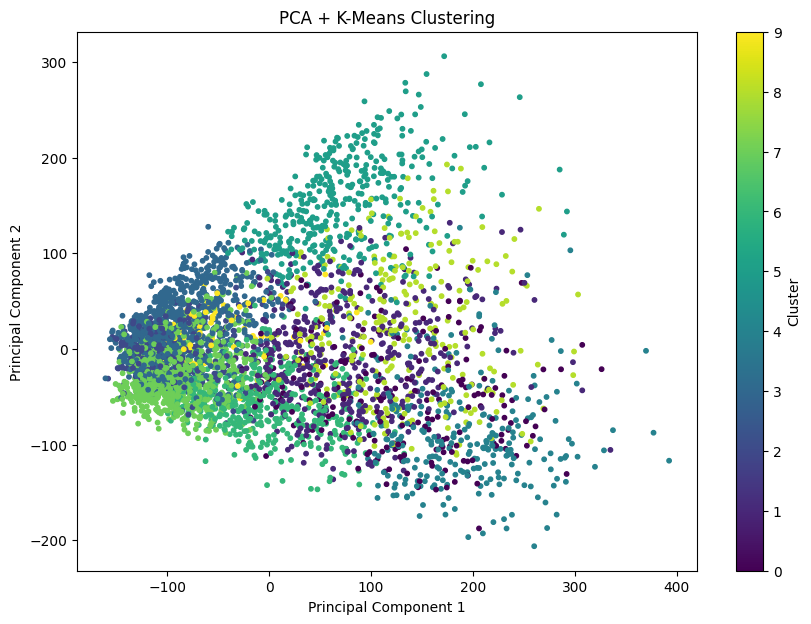

Cluster 0: 223 images


Cluster 1: 440 images


Cluster 2: 327 images


Cluster 3: 881 images


Cluster 4: 293 images


Cluster 5: 417 images


Cluster 6: 452 images


Cluster 7: 765 images


Cluster 8: 280 images


Cluster 9: 83 images




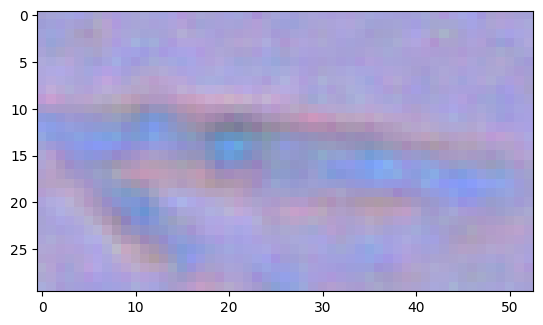

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Apply K-Means clustering to the reduced features
kmeans = KMeans(n_clusters=10)  # Adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(reduced_features)

# Visualize the clusters in 2D (you can use other visualization techniques as well)
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Explore images within each cluster
for cluster_id in range(10):  # Iterate through each cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    print(f"Cluster {cluster_id}: {len(cluster_indices)} images")
    # Print or display images from image_paths using cluster_indices
    for idx in cluster_indices[:5]:  # Print first 5 images in each cluster
        img_path = image_paths[idx]
        # Display the image or print its path
        # plt.imshow(image.load_img(img_path))
        print(img_path)
    print('\n')


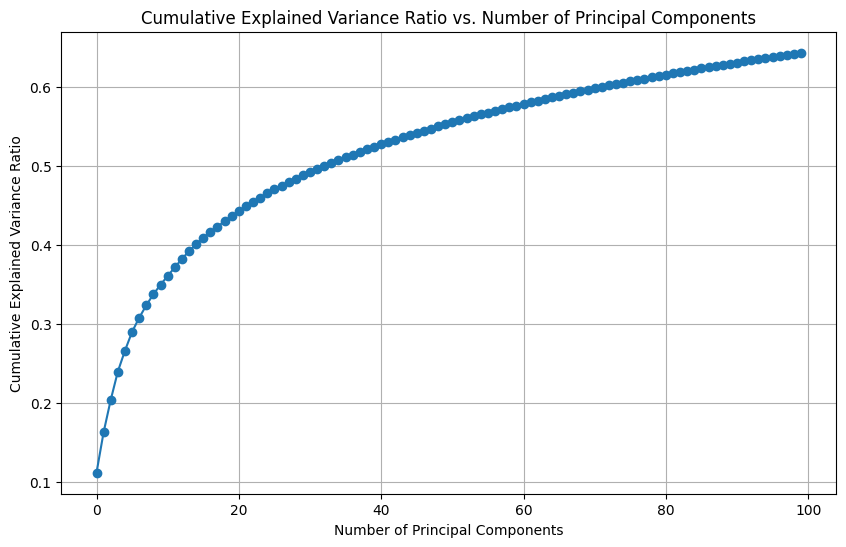

Number of selected components to retain 0.64 of variance: 98


In [26]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=100)
pca.fit(features_matrix)

# Compute explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Check if explained variance ratio is empty
if len(explained_variance_ratio) == 0 or np.sum(explained_variance_ratio) == 0:
    raise ValueError("Explained variance ratio is empty or sum of explained variance is zero. Ensure PCA is properly fitted.")

# Plot explained variance ratio to visualize the contribution of each component
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Select principal components based on desired threshold or cumulative explained variance ratio
desired_variance_ratio = 0.64
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

if len(cumulative_variance_ratio) > 0:
    selected_components = np.where(cumulative_variance_ratio >= desired_variance_ratio)[0]
    if len(selected_components) > 0:
        selected_components = selected_components[0] + 1
    else:
        raise ValueError("No components selected. Adjust the desired variance ratio.")
else:
    raise ValueError("Cumulative variance ratio is empty. Unable to select components.")

# Print the number of selected components
print(f"Number of selected components to retain {desired_variance_ratio} of variance: {selected_components}")

# Transform data using only the selected principal components
pca_selected = PCA(n_components=selected_components)
features_selected = pca_selected.fit_transform(features_matrix)


c:\Users\trist\miniconda3\envs\cv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of samples in each cluster:
[ 999 2480  682]


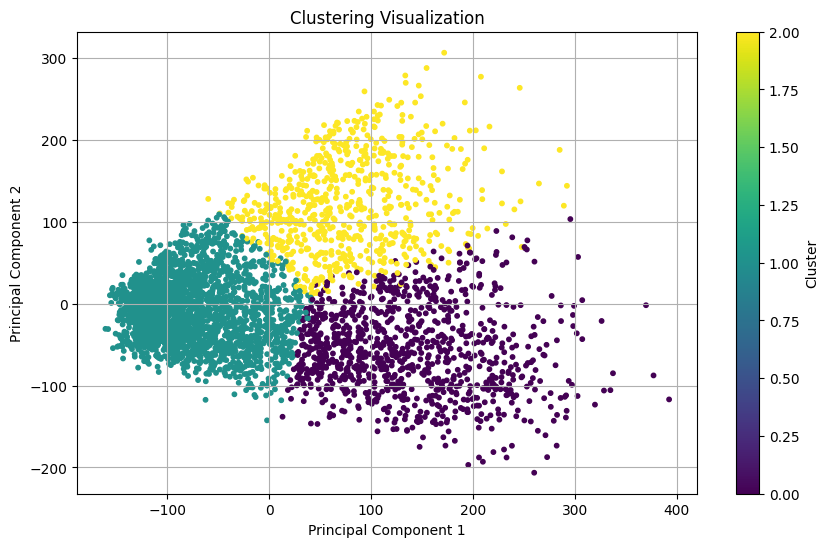

In [41]:
from sklearn.cluster import KMeans

# Initialize K-Means with the desired number of clusters
num_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit K-Means to the selected principal components
cluster_labels = kmeans.fit_predict(features_selected)

# Print the number of samples in each cluster
print("Number of samples in each cluster:")
print(np.bincount(cluster_labels))

plt.figure(figsize=(10, 6))
plt.scatter(features_selected[:, 0], features_selected[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Visualization')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [42]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
silhouette_avg = silhouette_score(features_selected, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.1879410445690155


In [43]:
from sklearn.metrics import davies_bouldin_score

# Compute the Davies–Bouldin index
db_index = davies_bouldin_score(features_selected, cluster_labels)
print(f"Davies–Bouldin Index: {db_index}")


Davies–Bouldin Index: 2.7025729254786746


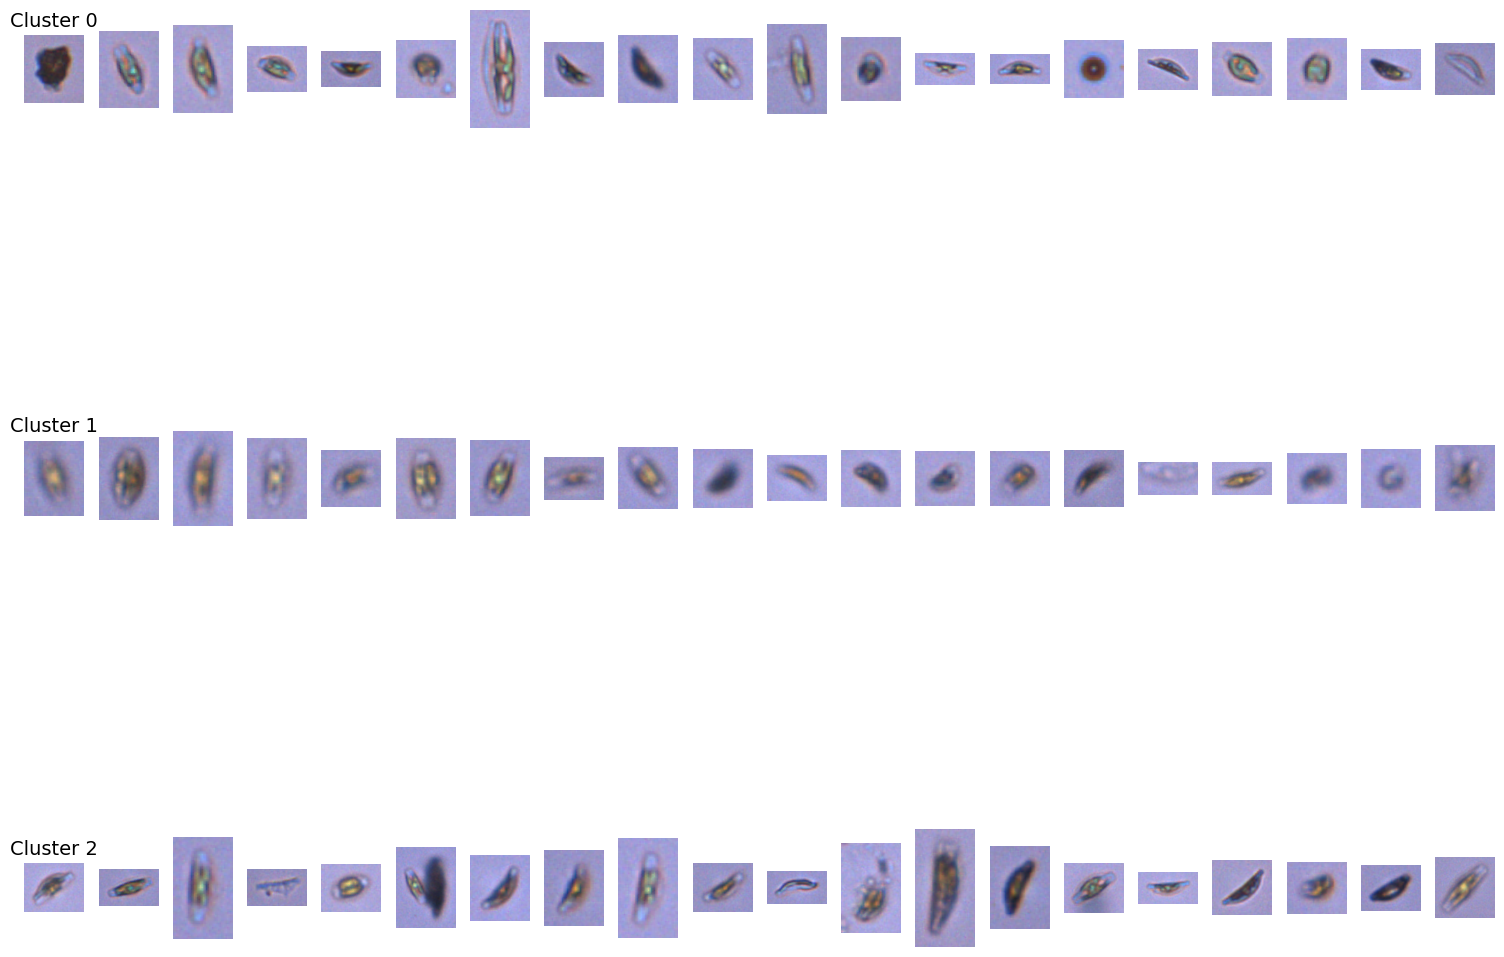

In [48]:
import matplotlib.pyplot as plt
import random

# Define the number of clusters
num_clusters = 3

# Define the number of images to display from each cluster
num_images_per_cluster = 10

# Create a figure and axis object
fig, axs = plt.subplots(num_clusters, num_images_per_cluster, figsize=(15, 15))

# Iterate over each cluster
for i in range(num_clusters):
    # Get indices of samples in the current cluster
    cluster_indices = np.where(cluster_labels == i)[0]
    
    # Randomly select a few images from the current cluster
    selected_indices = random.sample(list(cluster_indices), min(num_images_per_cluster, len(cluster_indices)))
    
    # Plot each selected image
    for j, idx in enumerate(selected_indices):
        img_path = image_paths[idx]
        img = image.load_img(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
    
    # Add title to the row indicating the cluster number
    axs[i, 0].set_title(f"Cluster {i}", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()
